# Предсказание рейтинга отелей


In [84]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from bs4 import BeautifulSoup as bs
import geocoder
import re
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from sklearn.preprocessing import OrdinalEncoder
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Эрнест\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [134]:
sample_submission = pd.read_csv('sf-booking/submission.csv')

In [135]:
train_data = pd.read_csv('sf-booking/hotels_train.csv')
print(train_data.shape)
train_data.head()

(386803, 17)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [136]:
test_data = pd.read_csv('sf-booking/hotels_test.csv')
print(test_data.shape)
test_data.head()

(128935, 16)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [137]:
# Загрузим данные по ВВП
gdp = pd.read_excel('https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel',header=3)

gdp.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.727850e+09,2.790849e+09,2.962905e+09,2.983637e+09,3.092430e+09,3.202189e+09,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.008272e+10,2.050945e+10,2.235043e+10,2.675866e+10,2.446499e+10,2.787894e+10,...,9.505214e+11,9.642424e+11,9.848071e+11,9.199300e+11,8.733549e+11,9.853557e+11,1.012853e+12,1.009910e+12,9.207923e+11,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.990732e+10,2.014640e+10,2.049713e+10,1.913421e+10,1.811656e+10,1.875347e+10,1.805323e+10,1.879945e+10,2.011614e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.040428e+10,1.112805e+10,1.194335e+10,1.267652e+10,1.383858e+10,1.486247e+10,...,7.275714e+11,8.207876e+11,8.649666e+11,7.607297e+11,6.905430e+11,6.837416e+11,7.416916e+11,7.945725e+11,7.845876e+11,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.941719e+10,5.837598e+10,NaN


In [138]:
# Отбросим лишние данные и преобразуем в словарь
cols_to_drop = list(gdp.columns)
cols_to_drop.remove('2020')
gdp.index = gdp['Country Name']
gdp.drop(cols_to_drop,axis=1,inplace=True)
gdp = gdp.to_dict(orient='index')

In [139]:
# Найдем данные об индексе Джини и населению стран
url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
page = requests.get(url)

soup = bs(page.content, 'html.parser')
tbl = soup.find("table")

gini_index = pd.read_html(str(tbl))[0]

gini_index.head()

,Country,Gini % - World Bank,Data Year (World Bank),Gini % - CIA World Factbook,Data Year (CIA),2022 Population
0,South Africa,63.0,2014.0,63.0,2014.0,60756135
1,Namibia,59.1,2015.0,59.1,2015.0,2633874
2,Suriname,57.9,1999.0,NaN,NaN,596831
3,Zambia,57.1,2015.0,57.1,2015.0,19470234
4,Sao Tome And Principe,56.3,2017.0,56.3,2017.0,227679


In [140]:
# Отделим лишнее и преобразуем в словарь для быстрого доступа
gini_index.index = gini_index['Country']
gini_index.drop(['Country','Data Year (World Bank)','Gini % - CIA World Factbook','Data Year (CIA)'],axis=1,inplace=True)
gini_index = gini_index.to_dict(orient='index')

In [141]:
# Уберем дубликаты
train_data.drop_duplicates(inplace=True,ignore_index=True)


In [142]:
# Соберем все в один DataFrame
train_data['sample'] = 1
train_data['id'] = train_data.index
test_data['sample'] = 0
test_data['reviewer_score'] = 0
test_data['id'] = test_data.index
hotel = train_data.copy()
hotel = pd.concat([train_data,test_data],axis=0,ignore_index=True)

hotel.shape

(515431, 19)

In [143]:
def create_expert_feats(data):
    """Метод добавления, очистки и подготовки признаков.

    Args:
        data (pd.DataFrame): входной DataFrame

    Returns:
        pd.DataFrame: обработанный DataFrame
    """
    # Получим список адресов отелей с координатами
    h_df = data[['hotel_address','lat','lng']].groupby(by=['hotel_address'],as_index=True).mean()

    # Доопределим координаты отелей

    for i in h_df[h_df['lat'].isnull()].index:
        g =geocoder.arcgis(i) # Запрос координат через модуль geocoder
        h_df.at[i,'lat'] = g.latlng[0]
        h_df.at[i,'lng'] = g.latlng[1]

    # Разберем адрес на страну и город
    h_df['country'] = ''
    
    h_df['addres'] = h_df.index
    h_df['country'] = h_df['addres'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

    # Преобразуем в словарь для удобства доступа
    latlng_dict = h_df.to_dict(orient='index')
    
    # Определим входящие в сеть отели
    data['hotel_net'] = data['hotel_name'].apply(
    lambda x: re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x)[0] \
        if (re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x) is not None) \
    else 'Not_in_net'
    )
    
    # Дооперелеим страну и город
    data['country'] = ''
    data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

    # Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран с отелем
    data['hc_gini'] = data['country'].apply(lambda x: gini_index[x]['Gini % - World Bank'])
    data['hc_population'] = data['country'].apply(lambda x: gini_index[x]['2022 Population'])
    data['hc_gdp'] = data['country'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)

    # Поправим представление данных о национальности, оно имеет пробелы в конце и начале
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])
    
    # Поправим данные об Америке
    us_list = ['Jersey','United States of America']
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'United States' if x in us_list else x)

    # Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран ревьюера
    data['rc_gini'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['Gini % - World Bank'] if gini_index.get(x) is not None else 0)
    data['rc_population'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['2022 Population'] if gini_index.get(x) is not None else 0)
    data['rc_gdp'] = data['reviewer_nationality'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)
    
    # Дозапоним индексы Джини медианным значением
    data['rc_gini'].fillna(data['rc_gini'].median(),inplace=True)
    data['rc_gdp'].fillna(data['rc_gdp'].median(),inplace=True)

    # Заполним координаты в главном DataFrame'е
    for i in data[data['lat'].isnull()].index:
        data.at[i,'lat'] = latlng_dict[data['hotel_address'][i]]['lat']
        data.at[i,'lng'] = latlng_dict[data['hotel_address'][i]]['lng']
    
    # Приведем столбец days_since_review в int
    data['days_since_review'] = data['days_since_review'].apply(lambda x: re.search(r'\d+', x)[0])
    data['days_since_review'] = data['days_since_review'].astype('int')
    
    # Разберем тэги
    data['tags'] = data['tags'].apply(lambda x: x.lower())
    data['tags_list'] = data['tags'].apply(lambda x: re.findall(r'\' ([\w ]+) \'', x))
    tags_list = []
    
    tags_list = []
    for i in data.index:
        for val in data['tags_list'][i]:
            tags_list.append(val)
    
    sent_analyzer = SentimentIntensityAnalyzer()
    
    tags_cnt = collections.Counter(tags_list)
    top_tags_set = set([key for key, _ in tags_cnt.most_common(10)])
    
    data['tags'] = data['tags_list'].apply(lambda x: '|'.join(sorted(list(top_tags_set.intersection(set(x))))))
    
    # Анализируем отзывы
    data['rw_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
    data['rw_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 
    
    data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
    data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
    
    # Разберем негативные комменты
    data['negative_review'] = data['negative_review'].apply(lambda x: x.lower())
    data['negative_rev_words_list'] = data['negative_review'].apply(lambda x: x.split(' '))
    negative_rev_words_list = []
    for i in data.index:
        for val in data['negative_rev_words_list'][i]:
            negative_rev_words_list.append(val)  
              
    negative_rev_words_cnt = collections.Counter(negative_rev_words_list)
    top_negative_rev_words_set = set([key for key, _ in negative_rev_words_cnt.most_common(5)])
    
    data['negative_rev_words_list'] = data['negative_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_negative_rev_words_set.intersection(set(x))))))
    
    # Разберем позитивные комменты
    data['positive_review'] = data['positive_review'].apply(lambda x: x.lower())
    data['positive_rev_words_list'] = data['positive_review'].apply(lambda x: x.split(' '))
    positive_rev_words_list = []
    for i in data.index:
        for val in data['positive_rev_words_list'][i]:
            positive_rev_words_list.append(val)  
              
    positive_rev_words_cnt = collections.Counter(positive_rev_words_list)
    top_positive_rev_words_set = set([key for key, _ in positive_rev_words_cnt.most_common(5)])
    
    data['positive_rev_words_list'] = data['positive_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_positive_rev_words_set.intersection(set(x))))))
    
    # Разберемся со столбцом национальности ревьюера
    rnat_list = []

    for i in data.index:
        rnat_list.append(data['reviewer_nationality'][i]) 
        
    rnat_cnt = collections.Counter(rnat_list)
    top_rnat_set = set([key for key, _ in rnat_cnt.most_common(5)])
    
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_rnat_set else 'other')    
    
    to_ordenc_list = ['reviewer_nationality','country','positive_rev_words_list','negative_rev_words_list','tags','hotel_net']
    enc = OrdinalEncoder()
    enc.fit(data[to_ordenc_list])
    data[to_ordenc_list] = enc.transform(data[to_ordenc_list])

    data['neg_len'] = data['negative_review'].map(len)
    data['pos_len'] = data['positive_review'].map(len)

    # Выведем процентное содержание позитивных и негативных слов
    data['positive_word_per'] = 100 * data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
    data['negative_word_per'] = 100 * data['review_total_negative_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
    data['#_pos_words'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
    data['#_neg_words'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
    data['pos_rev_rate'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews']
    data['neg_rev_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
    data['positive_word_per'].fillna(0,inplace=True)
    data['negative_word_per'].fillna(0,inplace=True)
    data['add_pos_rate'] = data['review_total_positive_word_counts'] / data['additional_number_of_scoring']
    data['add_neg_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
    
    data['review_rate'] = data['total_number_of_reviews_reviewer_has_given'] / data['total_number_of_reviews']

        
    # Разберем дату на признаки
    data['review_date'] = pd.to_datetime(data['review_date'])
    
    data['year'] = data['review_date'].dt.year
    data['month'] = data['review_date'].dt.month
    data['day'] = data['review_date'].dt.day
    data['dayofweek'] = data['review_date'].dt.dayofweek

    # Убираем лишние столбцы в виде дат и типа odject
    data.drop('review_date', axis = 1, inplace=True)
    
    object_columns = [s for s in data.columns if data[s].dtypes == 'object']
    data.drop(object_columns, axis = 1, inplace=True)

    return data

#train_data = create_expert_feats(train_data)
#test_data = create_expert_feats(test_data)
hotel = create_expert_feats(hotel)

In [95]:
def info_data(data,raw):
    """ Вывод информации о столбцах, пропусках
        и дубликатах DF.
    
    Args: 
        data: входной DataFrame
        
    Returns:
        str: пробел   
    """
    display(data.head(raw), data.shape)
    df = data.isnull().sum().values
    dd = data.duplicated().sum()
    print(f"\nДатафрейм имеет:\nпризнаков: {len(df)}\nдубликатов: {dd}\n")
    for i in range(len(df)):
        if df[i] != 0:
            di = data.count().index[i]
            print(f"Признак {di} имеет {str(df[i])} пропусков")
    if df.sum() == 0:
        print('Пропусков нет.')

In [146]:
info_data(hotel, 3)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,...,#_neg_words,pos_rev_rate,neg_rev_rate,add_pos_rate,add_neg_rate,review_rate,year,month,day,dayofweek
0,581,8.4,3.0,3,1994,4,7,10.0,46.0,531,...,0.428571,0.002006,0.001505,0.006885,0.001505,0.003511,2016,2,19,4
1,299,8.3,3.0,3,1361,2,14,6.3,3.0,203,...,0.214286,0.001470,0.002204,0.006689,0.002204,0.010287,2017,1,12,3
2,32,8.9,5.0,6,406,0,14,7.5,96.0,289,...,0.428571,0.000000,0.014778,0.000000,0.014778,0.034483,2016,10,18,1


(515431, 47)


Датафрейм имеет:
признаков: 47
дубликатов: 0

Пропусков нет.


In [147]:
# Разберем все обратно на два DataFrame'а
train_data = hotel[hotel['sample'] == 1]
test_data = hotel[hotel['sample'] == 0]
train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)

d:\anaconda\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [148]:
info_data(train_data, 3)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,...,#_neg_words,pos_rev_rate,neg_rev_rate,add_pos_rate,add_neg_rate,review_rate,year,month,day,dayofweek
id,,,,,,,,,,,,,,,,,,,,,
0,581,8.4,3.0,3,1994,4,7,10.0,46.0,531,...,0.428571,0.002006,0.001505,0.006885,0.001505,0.003511,2016,2,19,4
1,299,8.3,3.0,3,1361,2,14,6.3,3.0,203,...,0.214286,0.001470,0.002204,0.006689,0.002204,0.010287,2017,1,12,3
2,32,8.9,5.0,6,406,0,14,7.5,96.0,289,...,0.428571,0.000000,0.014778,0.000000,0.014778,0.034483,2016,10,18,1


(386496, 45)


Датафрейм имеет:
признаков: 45
дубликатов: 8

Пропусков нет.


In [149]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

In [107]:
train_data.drop_duplicates(inplace=True,ignore_index=True)
test_data.drop_duplicates(inplace=True,ignore_index=True)

C:\Users\311B~1\AppData\Local\Temp/ipykernel_13356/80070273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(inplace=True,ignore_index=True)
C:\Users\311B~1\AppData\Local\Temp/ipykernel_13356/80070273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(inplace=True,ignore_index=True)


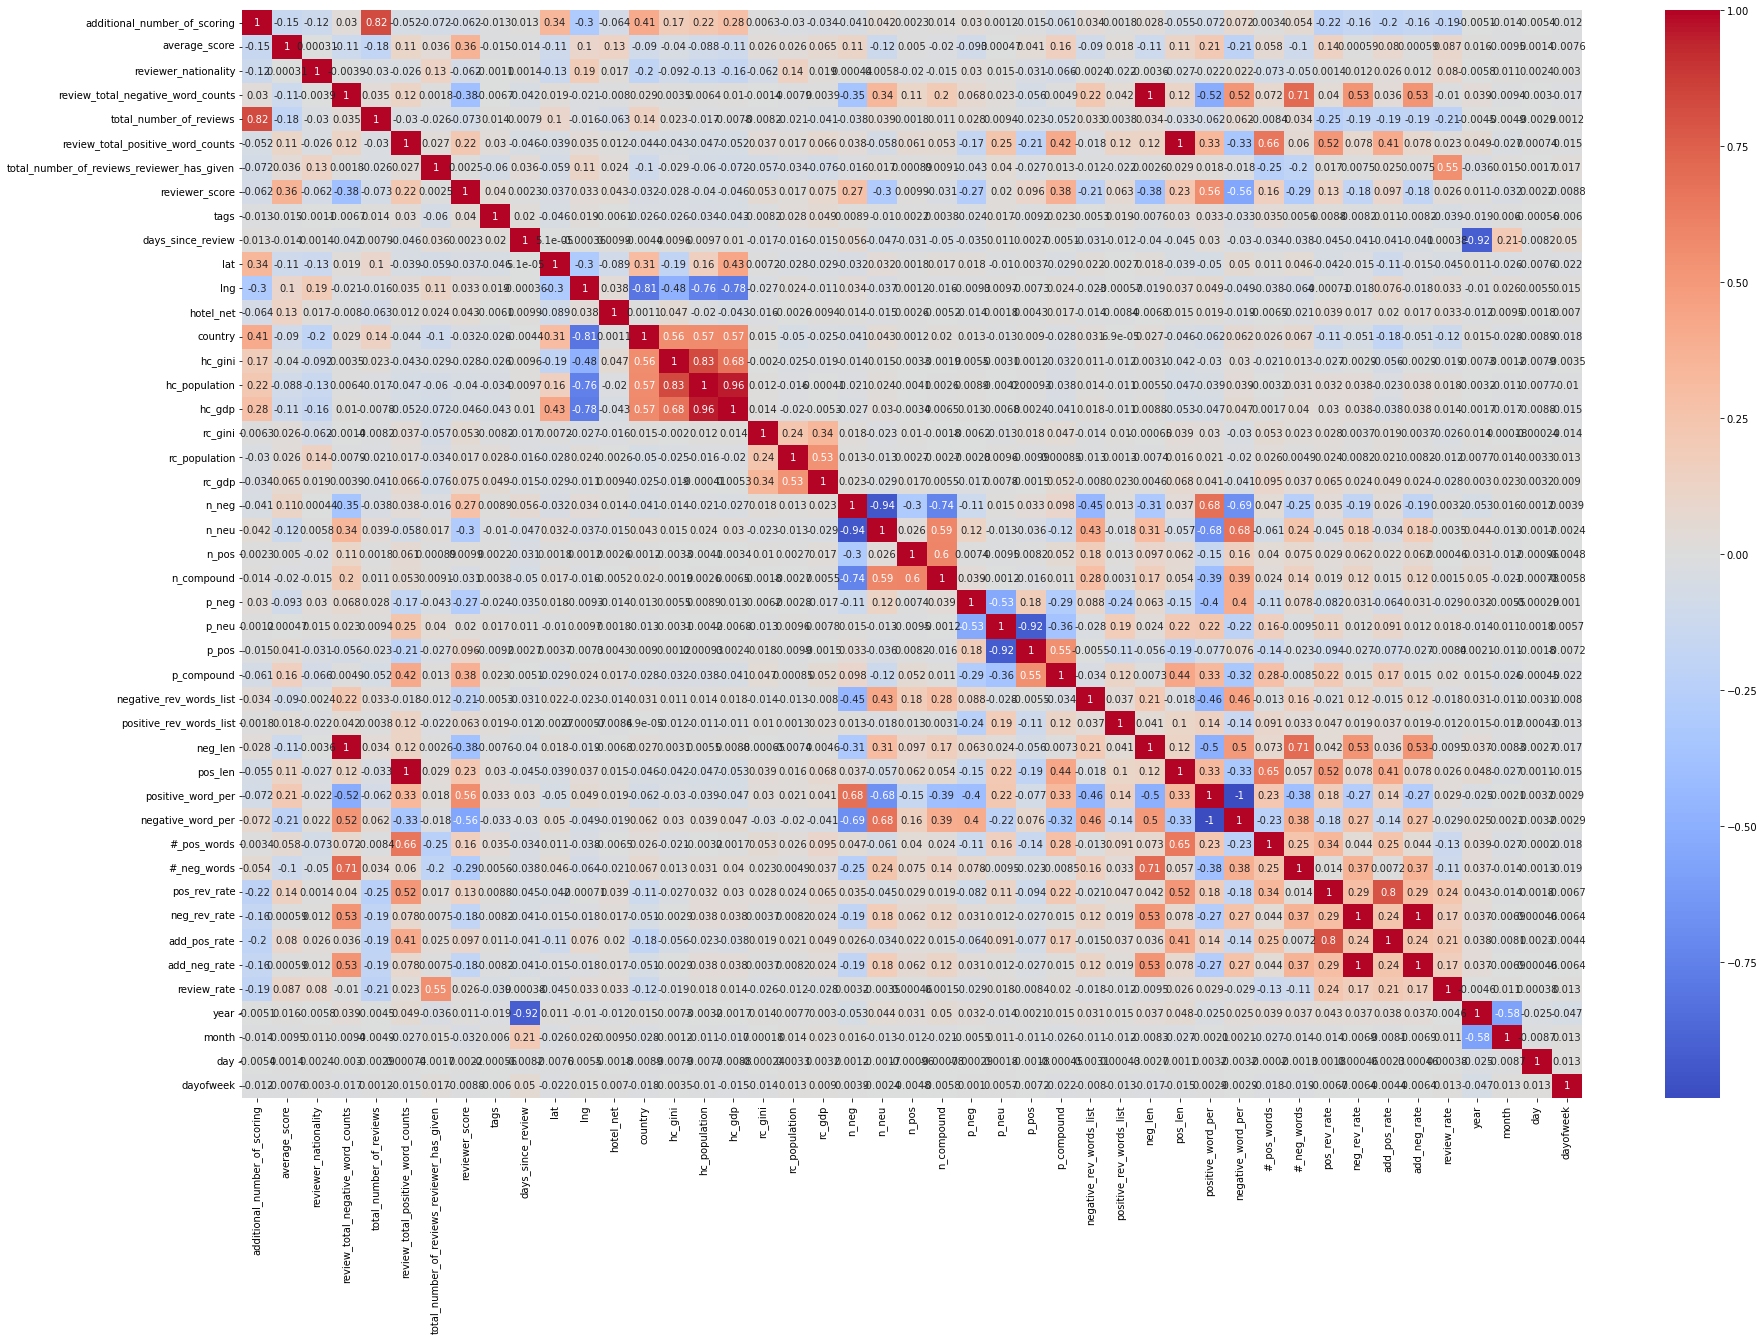

In [150]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm');

In [151]:
# Уберем признаки с мультиколлинеарностью
drop_col = ['hc_population','total_number_of_reviews','add_pos_rate','neg_rev_rate','review_total_positive_word_counts','n_neg','neg_len','positive_word_per']

train_data.drop(drop_col,axis=1,inplace=True)

d:\anaconda\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


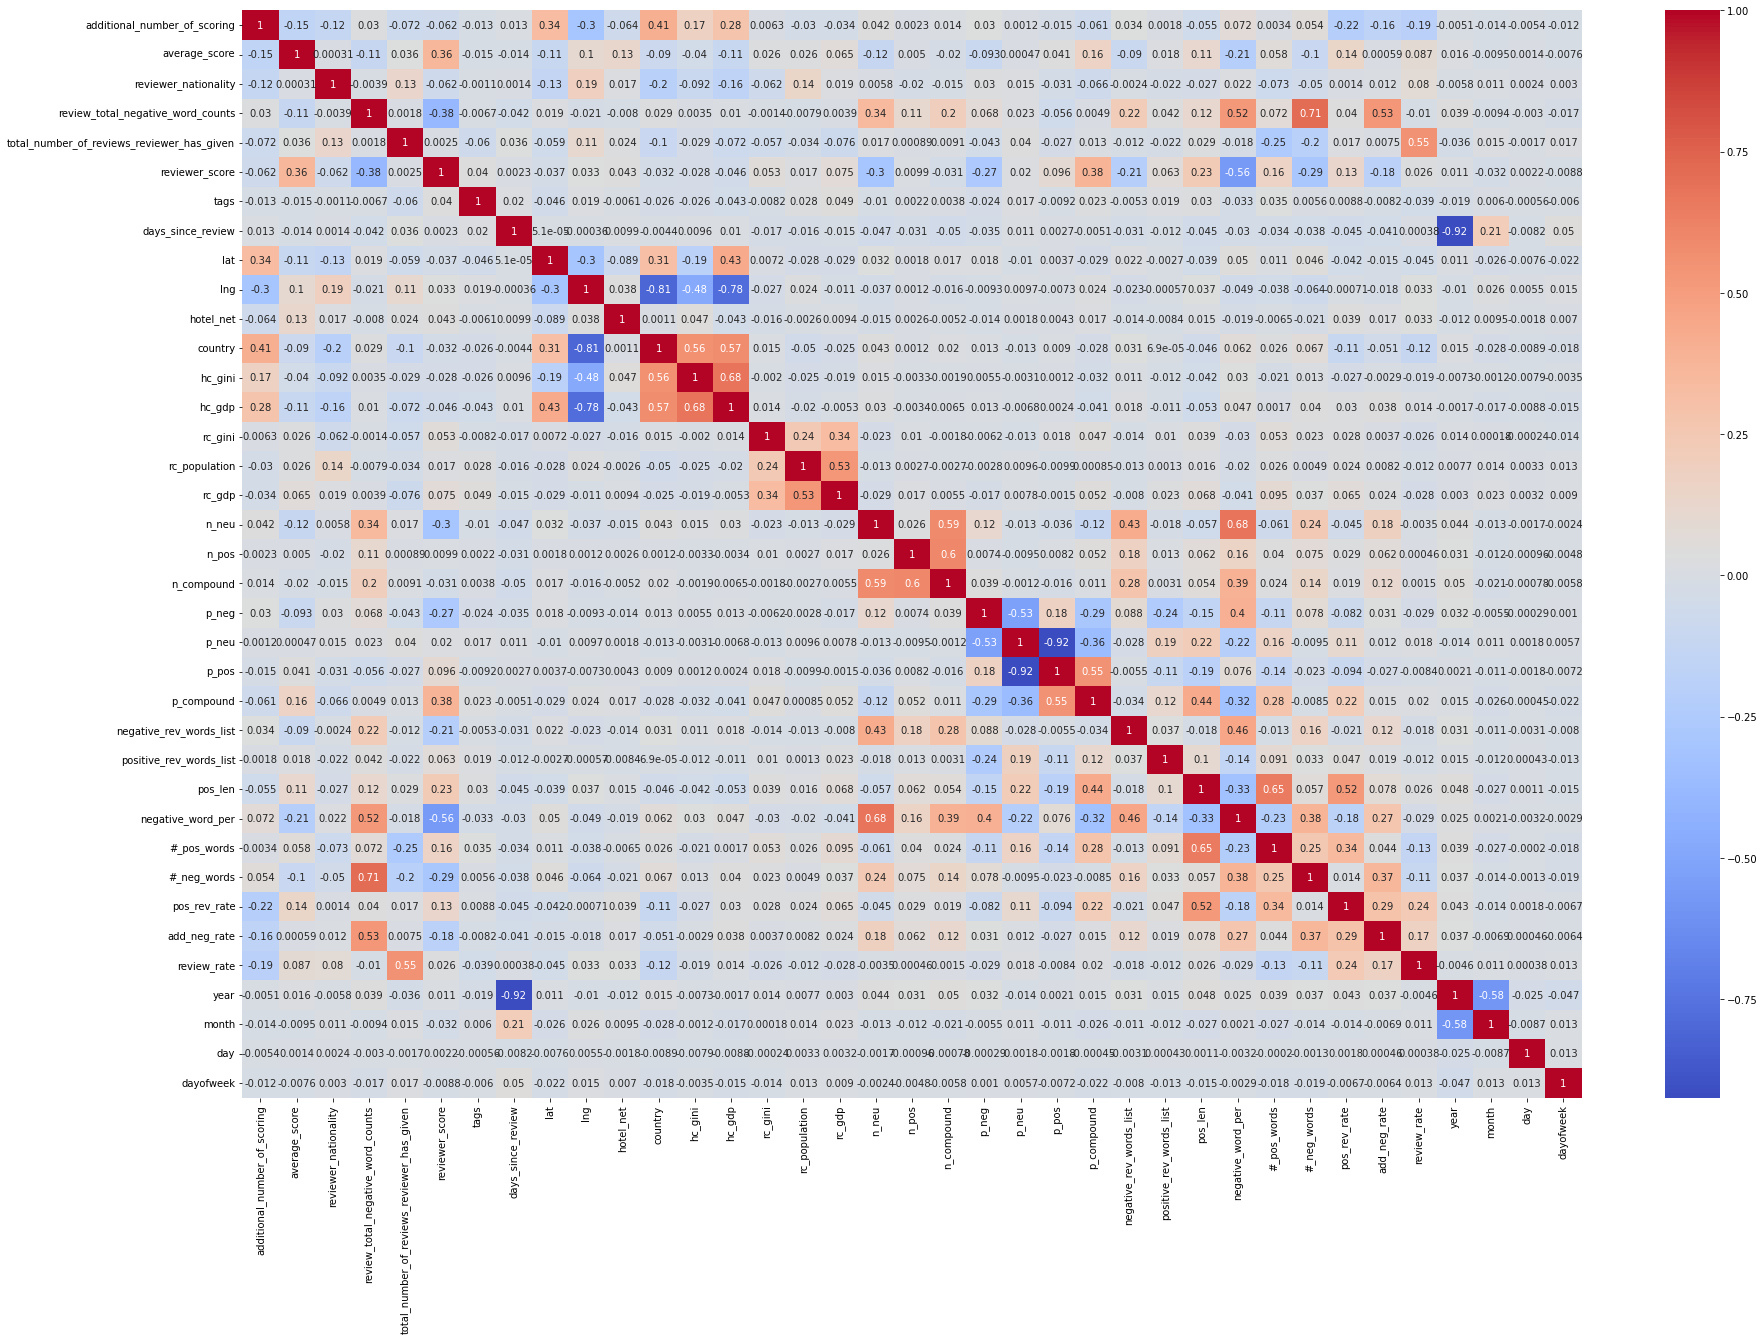

In [152]:
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm');

In [111]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [153]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
test_data

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,...,#_neg_words,pos_rev_rate,neg_rev_rate,add_pos_rate,add_neg_rate,review_rate,year,month,day,dayofweek
id,,,,,,,,,,,,,,,,,,,,,
0,904,8.1,3.0,52,16670,62,1,45.0,13,45.533137,...,52.000000,0.003719,0.003119,0.068584,0.003119,0.000060,2017,7,21,4
1,612,8.6,5.0,10,5018,0,7,75.0,234,52.385649,...,1.428571,0.000000,0.001993,0.000000,0.001993,0.001395,2016,12,12,0
2,46,8.3,5.0,3,351,5,15,28.0,616,41.393192,...,0.200000,0.014245,0.008547,0.108696,0.008547,0.042735,2015,11,26,3
3,241,9.1,4.0,0,1543,27,9,43.0,656,45.479888,...,0.000000,0.017498,0.000000,0.112033,0.000000,0.005833,2015,10,17,5
4,834,9.1,3.0,0,4687,7,2,30.0,444,52.370545,...,0.000000,0.001493,0.000000,0.008393,0.000000,0.000427,2016,5,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128930,53,8.1,5.0,0,984,4,14,2.0,547,45.502453,...,0.000000,0.004065,0.000000,0.075472,0.000000,0.014228,2016,2,3,2
128931,46,7.8,4.0,0,523,24,1,46.0,411,41.378169,...,0.000000,0.045889,0.000000,0.521739,0.000000,0.001912,2016,6,18,5
128932,260,8.0,5.0,31,3461,23,1,29.0,28,48.193523,...,31.000000,0.006645,0.008957,0.088462,0.008957,0.000289,2017,7,6,3


In [113]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

In [155]:
# Обучаем модель на тестовом наборе данных  
model.fit(X_train, y_train) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [156]:
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = model.predict(X_test) 

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [157]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12253728761091275


<AxesSubplot:>

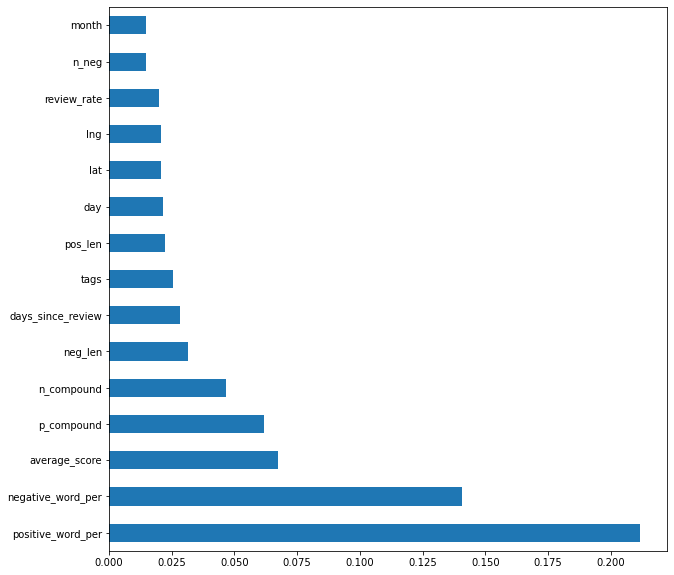

In [158]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [159]:
test_data.sample(10)

,additional_number_of_scoring,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,...,#_neg_words,pos_rev_rate,neg_rev_rate,add_pos_rate,add_neg_rate,review_rate,year,month,day,dayofweek
id,,,,,,,,,,,,,,,,,,,,,
41805,258,8.1,3.0,16,1018,13,6,29.0,71,51.508420,...,2.666667,0.012770,0.015717,0.050388,0.015717,0.005894,2017,5,24,2
23461,257,9.2,3.0,2,2116,10,1,48.0,66,41.390140,...,2.000000,0.004726,0.000945,0.038911,0.000945,0.000473,2017,5,29,0
102421,118,8.1,5.0,55,737,4,56,30.0,495,48.201986,...,0.982143,0.005427,0.074627,0.033898,0.074627,0.075984,2016,3,26,5
32357,118,8.9,3.0,0,1145,5,1,46.0,136,48.848305,...,0.000000,0.004367,0.000000,0.042373,0.000000,0.000873,2017,3,20,0
14006,765,8.4,3.0,59,4686,22,17,59.0,255,52.372707,...,3.470588,0.004695,0.012591,0.028758,0.012591,0.003628,2016,11,21,0
63440,96,8.9,5.0,16,883,6,4,47.0,359,41.595120,...,4.000000,0.006795,0.018120,0.062500,0.018120,0.004530,2016,8,9,1
71291,321,8.6,2.0,8,3557,0,1,101.0,688,48.231911,...,8.000000,0.000000,0.002249,0.000000,0.002249,0.000281,2015,9,15,1
34098,173,8.5,5.0,9,1799,4,7,28.0,411,48.209703,...,1.285714,0.002223,0.005003,0.023121,0.005003,0.003891,2016,6,18,5
3023,404,8.9,0.0,9,2197,37,2,96.0,286,51.516675,...,4.500000,0.016841,0.004096,0.091584,0.004096,0.000910,2016,10,21,4


In [160]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [161]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


In [162]:
predict_submission

array([8.372, 7.694, 8.585, ..., 8.387, 9.577, 7.336])

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)